In [1]:
import random
import pandas as pd
import numpy as np
import generate
import matplotlib.pyplot as plot

In [2]:
# data split window size
WindowSize = 10


In [10]:
dt = pd.read_csv('nyc_taxi.csv')

In [3]:
def sliding_window_data(inp, windowSize = 20):
    out = []
    for i in range(0,len(inp),windowSize):
        tmp = inp[i:i+windowSize]
        if len(tmp) == windowSize:
            out.append(tmp)
    return out
def add_random_noise(inp):
    pass
def add_random_anomaly(inp, windowSize = 20, no_of_anomalies = 10):
    # randomly generate anomaly with this size
    mi = 1#int(windowSize / 2)
    ma = WindowSize #int(WindowSize * 2)
    inMi = (min(inp) + max(inp) )/ 2 
    ret = [] # to keep record where we added anomaly    
    l = len(inp) / no_of_anomalies
    for i in range(no_of_anomalies):
        sz = random.randrange(mi,ma) # randomly generate size of anomaly
        #print(i*l)
        #print((i+1) * l)
        fr = random.randrange(int(i*l), int((i+1)*l))
        sr = random.randrange(fr,fr + (2*sz))
        ret.append((fr,sr))
        inp[fr:sr] = [inMi + random.uniform(-0.2,0.2) for _ in range(fr,sr)]
    return inp, ret

    pass

In [57]:
vals = list(dt['value'])
data = sliding_window_data(vals,windowSize=WindowSize)

In [4]:
vals = generate.generate(1000000)

In [5]:
data = sliding_window_data(vals,windowSize=WindowSize)

In [6]:
len(data)
perc = int(len(data) * 0.8)

In [7]:
train = np.array(data[:perc])
test = np.array(data[perc:])

In [8]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


In [9]:
input_dim = train.shape[1] #features
encoding_dim = WindowSize - 2
hidden_dim = int(encoding_dim / 2)
print(input_dim)

10


In [10]:
nb_epoch = 20
batch_size = 32
learning_rate = 0.001

In [11]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [12]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                90        
Total params: 254
Trainable params: 254
Non-trainable params: 0
_________________________________________________________________


In [13]:
#compile
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

In [14]:
history = autoencoder.fit(train, train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test, test),
                    verbose=1).history

Train on 28571 samples, validate on 7143 samples
Epoch 1/20
28571/28571 [==============================] - 1s 42us/step - loss: 0.5763 - accuracy: 0.0840 - val_loss: 0.3896 - val_accuracy: 0.1098
Epoch 2/20
28571/28571 [==============================] - 1s 32us/step - loss: 0.3279 - accuracy: 0.1145 - val_loss: 0.3179 - val_accuracy: 0.1098
Epoch 3/20
28571/28571 [==============================] - 1s 32us/step - loss: 0.3015 - accuracy: 0.2639 - val_loss: 0.2876 - val_accuracy: 0.4404
Epoch 4/20
28571/28571 [==============================] - 2s 66us/step - loss: 0.2861 - accuracy: 0.4829 - val_loss: 0.2850 - val_accuracy: 0.5232
Epoch 5/20
28571/28571 [==============================] - 1s 33us/step - loss: 0.2713 - accuracy: 0.5940 - val_loss: 0.2603 - val_accuracy: 0.5621
Epoch 6/20
28571/28571 [==============================] - 1s 51us/step - loss: 0.2595 - accuracy: 0.5366 - val_loss: 0.2589 - val_accuracy: 0.5208
Epoch 7/20
28571/28571 [==============================] - 1s 43us/ste

In [99]:
autoencoder.save("model.h5")

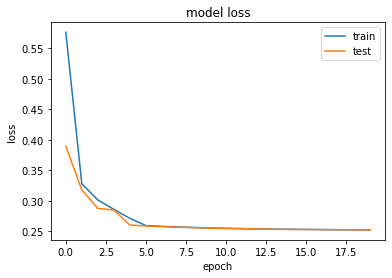

In [16]:
plot.plot(history['loss'])
plot.plot(history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

In [17]:
for_test = generate.generate(1000)

for_test, locs = add_random_anomaly(for_test, WindowSize, 5)

anomalyData = np.array(sliding_window_data(for_test,windowSize=WindowSize))

In [6]:
autoencoder = load_model('model.h5')
#print(f'Min Loss:{np.min(history["loss"])}')

In [18]:
anomalyData[0]

array([0.99994272, 0.01749011, 0.63346359, 1.84568955, 1.68190634,
       0.40858519, 0.09738811, 1.25462506, 1.99750014, 1.11737399])

In [19]:
predictions = autoencoder.predict(anomalyData)
mse = np.mean(np.power(anomalyData - predictions, 2), axis=1)
print('MSE:', np.quantile(mse, 0.9999)) # => the 9999% quatile - only 0.0001% have error score higher than that

MSE: 1.5272626675731384


In [20]:
for a,p,e in zip(anomalyData,predictions, mse):
    print(a,p,e)
#print("MSE", np.mean(np.power(anomalyData - predictions, 2), axis=1))

[0.99994272 0.01749011 0.63346359 1.84568955 1.68190634 0.40858519
 0.09738811 1.25462506 1.99750014 1.11737399] [0.90912724 0.02320302 0.7078213  0.99999994 0.99999565 0.36323735
 0.08617979 0.9959504  0.9999623  0.9611289 ] 0.22825912396814302
[0.04619007 0.52673813 1.77717835 1.76307544 0.50737447 0.05306986
 1.13930397 1.99880077 1.23318024 0.08808803] [0.04327471 0.5694062  0.9997758  0.9999999  0.49577758 0.02417452
 0.9711251  0.99999    0.98271704 0.08141348] 0.227812096662699
[0.42656085 1.69791179 1.83368432 0.6129799  0.02185442 1.02205441
 1.98627924 1.34575895 0.14260422 0.33431802] [ 0.43412355  0.9998922   0.9998088   0.65745234 -0.01125655  0.9523803
  0.99999464  0.99801016  0.12571868  0.3191471 ] 0.2284767411554543
[1.60898674 1.89275591 0.72394011 0.00417373 0.90449887 1.9601088
 1.45355228 0.20898423 0.25128608 1.51163377] [0.99999297 0.9999548  0.8379165  0.00180068 0.89336836 0.99990976
 0.9983245  0.22366913 0.24153267 0.99981743] 0.257256859536121
[1.93947278e+

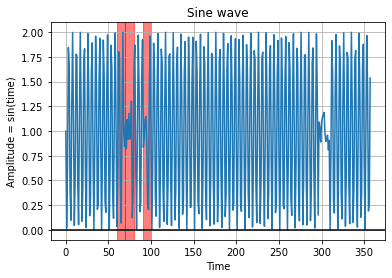

<Figure size 432x288 with 0 Axes>

In [25]:
time = [i for i in range(len(for_test))]
# Plot a sine wave using time and amplitude obtained for the sine wave
plot.plot(time, for_test)
# Give a title for the sine wave plot
plot.title('Sine wave')
# Give x axis label for the sine wave plot
plot.xlabel('Time')

for ind, e in enumerate(mse):
    if e > 0.4:
        plot.axvspan(ind*WindowSize, (ind+1)*WindowSize, color='red', alpha=0.5)

# Give y axis label for the sine wave plot
plot.ylabel('Amplitude = sin(time)')
plot.grid(True, which='both')
plot.axhline(y=0, color='k')
plot.show()
plot.savefig("test.png")